# Preprocessing of heat demand dataset for BASOPRA_extended

The heat demand data is used to size the heat pump according to the Appendix A and C of The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38 Part B: Buildings and Space Heat Load. Once the heat pump size is known, the heating system' supply and return temperatures for the three types of houses are calculated for space heating and domestic hot water. Finally, the COP is calculated for the distribution temperature and the output temperature

## TODO: Include GSHP

In [2]:
normal_size=16

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_27724\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import math

In [6]:
df=pd.read_csv('../Input/Heat_demand_new_15.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
#df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_27724\3194641654.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv('../Input/Heat_demand_new_15.csv',engine='python',sep=',|;',index_col=[0],


In [ ]:
df.sum().round(1)

Hour          153457680.0
Set_T            700800.0
Temp             396586.8
SFH15_kWh          3880.1
SFH45_kWh          9876.2
SFH100_kWh        22843.3
DHW_kWh            3682.2
dtype: float64

<Axes: >

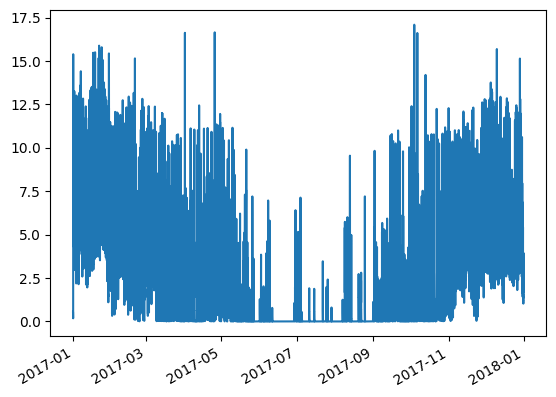

In [11]:
(df.loc[:,'SFH100_kWh']*4).plot()

In [5]:
if np.issubdtype(df.index.dtype, np.datetime64):
            df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

In [6]:
df.index

DatetimeIndex(['2017-01-01 00:00:00+01:00', '2017-01-01 00:15:00+01:00',
               '2017-01-01 00:30:00+01:00', '2017-01-01 00:45:00+01:00',
               '2017-01-01 01:00:00+01:00', '2017-01-01 01:15:00+01:00',
               '2017-01-01 01:30:00+01:00', '2017-01-01 01:45:00+01:00',
               '2017-01-01 02:00:00+01:00', '2017-01-01 02:15:00+01:00',
               ...
               '2017-12-31 21:30:00+01:00', '2017-12-31 21:45:00+01:00',
               '2017-12-31 22:00:00+01:00', '2017-12-31 22:15:00+01:00',
               '2017-12-31 22:30:00+01:00', '2017-12-31 22:45:00+01:00',
               '2017-12-31 23:00:00+01:00', '2017-12-31 23:15:00+01:00',
               '2017-12-31 23:30:00+01:00', '2017-12-31 23:45:00+01:00'],
              dtype='datetime64[ns, Europe/Brussels]', length=35040, freq=None)

According to Appendix A if the IEA SHC task 44, the distribution of the outdoor temperature is shown and the ambient design temperature is calculated

In [7]:
from scipy import optimize
def yearly_temps(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))


According to Appendix A "the outdoor design temperature is defined as the lowest temperature to lie in the z=2.57*sigma quantile i.e. the confidence interval of p=0.99"

In [8]:
y_data=df.Temp.values
x_data=np.linspace(0,math.pi,35040)

opt_results, covariance = optimize.curve_fit(yearly_temps, x_data,
                                      y_data, [20, 10, 0])
temp_deviation_from_sine_fit=yearly_temps(x_data,*opt_results)-y_data


In [1]:

fig,ax=plt.subplots(1,2,figsize=(15,8))

ax[0].plot(x_data,y_data)
ax[0].plot(x_data,yearly_temps(x_data, *opt_results), 'r-')#The * send the whole array a separated as if a[0],a[1],a[2] were sent
ax[0].set_xlabel('time [h]',size=normal_size)
ax[0].set_ylabel('Outdoor temperature\n[°C]',size=normal_size)
ax[0].set_yticklabels(ax[0].get_yticks(),size=normal_size)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(math.pi/5))
ax[0].set_xlim(0,3.1415)
ax[0].set_xticklabels((ax[0].get_xticks()/math.pi*8600).astype(int),size=normal_size)

#plt.text(-55,2150,'a)',size=normal_size)

ax[0].text(0.05,32,'y(x)=a+b*cos((x+c)*2*π/max(x))',size=normal_size)
ax[0].text(0.05,30,'a={}'.format(opt_results.round(3)[0]),size=normal_size-2)
ax[0].text(0.05,28,'b={}'.format(opt_results.round(3)[1]),size=normal_size-2)
ax[0].text(0.05,26,'c={}'.format(opt_results.round(3)[2]),size=normal_size-2)
#ax.text(0.05,24,'{})'.format(opt_results.round(3)[3]))
#fig.savefig('Geneva_temp_dist.pdf')
print('The fitting function has the form a+b*cos((x+c)*2*pi/max(x))')
print('{}+{}*cos((x+{})*2)'.format(*opt_results))


conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
print(design_temp)
#plt.text(-20,2150,'b)',size=normal_size)
ax[1].hist(temp_deviation_from_sine_fit,bins=50)
ax[1].axvline(x=design_temp,color='r',linestyle='--')
ax[1].set_xlabel('Δ T\n[°C]',size=normal_size)
ax[1].set_ylabel('Frequency',size=normal_size)
ax[1].set_yticklabels(ax[1].get_yticks(),size=normal_size)
ax[1].set_xticklabels(ax[1].get_xticks(),size=normal_size)
ax[1].text(-11.2,2000,'Design Temperature= {} °C'.format(design_temp.round(1)),rotation=90,size=normal_size)
plt.tight_layout()
plt.show()

#fig.savefig('outdoor_distribution.pdf')



NameError: name 'plt' is not defined

The design temperature is then set at -10°C

Now the heat load is estimated according to Appendix D and taking the heat demand from the df previously loaded

df is in kWh (Energy terms), we change it to kW (Power terms) taking into account the temporal resolution (15 minutes).

In [10]:
df_power=df.copy()
df_power.loc[:,['SFH15_kWh','SFH45_kWh','SFH100_kWh']]*=4

In [11]:
heat_load_ix=np.arange(-10,20,0.1)
heat_load=(df_power.groupby(df.Temp).mean()).loc[:,['SFH15_kWh','SFH45_kWh','SFH100_kWh']]
heat_load=heat_load.loc[heat_load.index<20]
z15 = np.polyfit(heat_load.index, heat_load.SFH15_kWh, 1)
z45 = np.polyfit(heat_load.index, heat_load.SFH45_kWh, 1)
z100 = np.polyfit(heat_load.index, heat_load.SFH100_kWh, 1)
fit_15=heat_load_ix*z15[0]+z15[1]
fit_45=heat_load_ix*z45[0]+z45[1]
fit_100=heat_load_ix*z100[0]+z100[1]

In [12]:
heatload_dt15=round(design_temp*z15[0]+z15[1],3)
heatload_dt45=round(design_temp*z45[0]+z45[1],3)
heatload_dt100=round(design_temp*z100[0]+z100[1],3)
print('The heat load at design ambient temperature for SFH15 is:{}'.format(heatload_dt15))
print('The heat load at design ambient temperature for SFH45 is:{}'.format(heatload_dt45))
print('The heat load at design ambient temperature for SFH100 is:{}'.format(heatload_dt100))

The heat load at design ambient temperature for SFH15 is:2.394
The heat load at design ambient temperature for SFH45 is:4.929
The heat load at design ambient temperature for SFH100 is:10.631


The minimum temperature of the dataset is -7.2 °C
-11.339605655303023


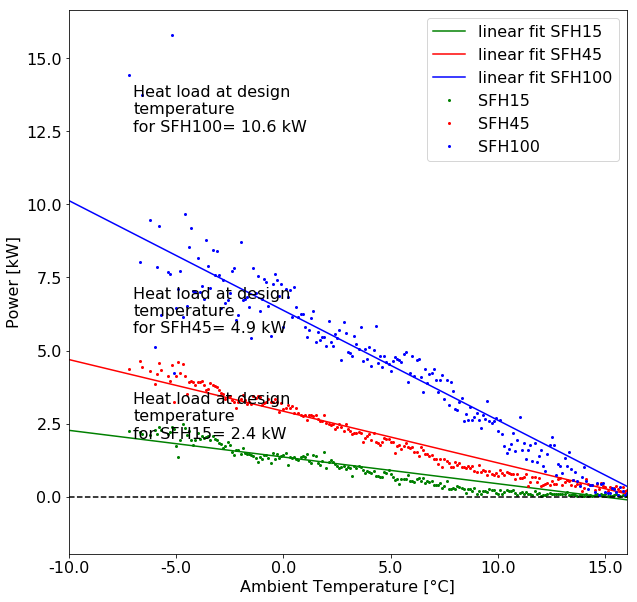

In [13]:



print('The minimum temperature of the dataset is {} °C'.format(df.Temp.min()))

fig,ax=plt.subplots(figsize=(10,10))

ax.plot(heat_load_ix, fit_15,'g-',label='linear fit SFH15')
ax.plot(heat_load_ix, fit_45,'r-',label='linear fit SFH45')
ax.plot(heat_load_ix, fit_100,'b-',label='linear fit SFH100')
ax.plot(heat_load.index,heat_load.SFH15_kWh,'ro',color='g',markersize=2,label='SFH15')
ax.plot(heat_load.index,heat_load.SFH45_kWh,'ro',color='r',markersize=2,label='SFH45')
ax.plot(heat_load.index,heat_load.SFH100_kWh,'ro',color='b',markersize=2,label='SFH100')

ax.set_xlim(-10,16)
ax.legend( prop={'size': normal_size})
ax.set_yticklabels(ax.get_yticks(),size=normal_size)
ax.set_xticklabels(ax.get_xticks(),size=normal_size)
ax.set_ylabel('Power [kW]',size=normal_size)
ax.set_xlabel('Ambient Temperature [°C]',size=normal_size)
conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
print(design_temp)
ax.axhline(y=0,color='k',linestyle='--')
ax.text(-7,2,'Heat load at design\ntemperature\nfor SFH15= {} kW'.format(heatload_dt15.round(1)),size=normal_size)
ax.text(-7,5.6,'Heat load at design\ntemperature\nfor SFH45= {} kW'.format(heatload_dt45.round(1)),size=normal_size)
ax.text(-7,12.5,'Heat load at design\ntemperature\nfor SFH100= {} kW'.format(heatload_dt100.round(1)),size=normal_size)

fig.savefig('daily_heating_power.pdf')

plt.show()

## Heat emission system
Taking the heat demand from the dataframe, the design ambient temperature, the design heat load and design supply temperature, the supply and return temperatures are calculated depending on the outdoor temperature. These calculations are based on the section 5 of the IEA SHC task 44.

d stands for design

In [14]:
dict_design={'heatload_dt15':heatload_dt15,'heatload_dt45':heatload_dt45,'heatload_dt100':heatload_dt100,'design_temp':design_temp,
             'T_dsupply_15_45':35,'T_dreturn_15_45':30,'T_dsupply_100':50,'T_dreturn_100':40,'T_dsupply_15_45_tank':40,
             'T_dreturn_15_45_tank':35,'T_dsupply_100_tank':55,'T_dreturn_100_tank':45,'rad_exp_15_45':1.1,'rad_exp_100':1.3}

In [15]:
aux=df.groupby(df.index.dayofyear).mean().Temp
df.loc[(df.index.hour==0)&(df.index.minute==0),'Temp_mean']=aux.values
df.Temp_mean=df.Temp_mean.ffill()

In [16]:
#def get_inlet_outlet_temp(df, dict_design):
    # '''
    # Description
    # ---------
    # Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
# Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    # Temperatures in Celsius or Kelvin
    # Parameters
    # ---------
    # df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    # dict_design:dict; design temperature, design heat load, design inlet (supply) and outlet (return) temperature
    # '''
    # if df.Temp[0]>200:#Kelvin
        # dict_design.update({'design_temp':design_temp+273.15,'T_dsupply_15_45':35+273.15,'T_dreturn_15_45':30+273.15,'T_dsupply_100':55+273.15,
             # 'T_dreturn_100':45+273.15})
    # df['Temp_supply_SFH15_45']=df.Set_T+((dict_design['T_dsupply_15_45']-dict_design['T_dreturn_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_15_45']+dict_design['T_dreturn_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    # df['Temp_supply_SFH100']=df.Set_T+((dict_design['T_dsupply_100']-dict_design['T_dreturn_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_100']+dict_design['T_dreturn_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    # #df['Temp_out_SFH15_45']=df.Set_T-((dict_design['T_din_15_45']-dict_design['T_dout_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_15_45']+dict_design['T_dout_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    # #df['Temp_out_SFH100']=df.Set_T-((dict_design['T_din_100']-dict_design['T_dout_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_100']+dict_design['T_dout_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    # df=df.fillna(0)
    # return

In [17]:
print(dict_design)

{'heatload_dt15': 2.394, 'heatload_dt45': 4.929, 'heatload_dt100': 10.631, 'design_temp': -11.339605655303023, 'T_dsupply_15_45': 35, 'T_dreturn_15_45': 30, 'T_dsupply_100': 50, 'T_dreturn_100': 40, 'T_dsupply_15_45_tank': 40, 'T_dreturn_15_45_tank': 35, 'T_dsupply_100_tank': 55, 'T_dreturn_100_tank': 45, 'rad_exp_15_45': 1.1, 'rad_exp_100': 1.3}


In [18]:
def find_interval_hp(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x <= partition[i]:
            return i
    if x >partition[i]:
        return i

In [19]:
heat_load_ix=np.arange(-10,15.1,0.1)

df1=pd.DataFrame([heat_load_ix,heat_load_ix*0+20]).T
df1.columns=['Temp_mean','Set_T']

In [20]:
def supply_temp(df,heatload,design_temp,T_supply,T_return,rad_exp):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    heatload:
    T_supply:
    T_return:
    rad_exp:
    Returns
    ---------
    Temperature of supply (pd.Series)
    '''
    df_sup=df.copy()
    
    df_sup['Q_herf']=np.heaviside(15-df_sup.Temp_mean,0)*heatload*(df_sup.Set_T-df_sup.Temp_mean)/(df_sup.Set_T-design_temp)

    df_sup['delta_t']=0.5*(T_supply+T_return)-df_sup.Set_T

    df_sup['second']=(df_sup.Q_herf/heatload)**(1/rad_exp)*df_sup.delta_t

    df_sup['third']=df_sup.Q_herf/(2*heatload)*(T_supply-T_return)
    return df_sup.Set_T+df_sup.second+df_sup.third

In [21]:
def return_temp(df,heatload,design_temp,T_supply,T_return,rad_exp):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    heatload:
    T_supply:
    T_return:
    rad_exp:
    Returns
    ---------
    Temperature of return (pd.Series)
    '''
    df_sup=df.copy()
    df_sup['second']=(T_supply-T_return)/2*(df_sup.Set_T-df_sup.Temp_mean)/(df.Set_T-design_temp)
    df_sup['third']=((T_supply+T_return)/2-df_sup.Set_T)*((df_sup.Set_T-df_sup.Temp_mean)/(df.Set_T-design_temp))**(1/rad_exp)
    return df_sup.Set_T-df_sup.second+(df_sup.third)*np.heaviside(15-df_sup.Temp_mean,0)

In [22]:
df1['Supply_T_15']=supply_temp(df1,dict_design['heatload_dt15'],dict_design['design_temp'],dict_design['T_dsupply_15_45'],dict_design['T_dreturn_15_45'],dict_design['rad_exp_15_45'])
df1['Supply_T_15_tank']=supply_temp(df1,dict_design['heatload_dt45'],dict_design['design_temp'],dict_design['T_dsupply_15_45_tank'],dict_design['T_dreturn_15_45_tank'],dict_design['rad_exp_15_45'])
df1['Supply_T_100']=supply_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],dict_design['T_dreturn_100'],dict_design['rad_exp_100'])
df1['Supply_T_100_tank']=supply_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100'])
df1['Return_T_15']=return_temp(df1,dict_design['heatload_dt15'],dict_design['design_temp'],dict_design['T_dsupply_15_45'],dict_design['T_dreturn_15_45'],dict_design['rad_exp_15_45'])
df1['Return_T_15_tank']=return_temp(df1,dict_design['heatload_dt45'],dict_design['design_temp'],dict_design['T_dsupply_15_45_tank'],dict_design['T_dreturn_15_45_tank'],dict_design['rad_exp_15_45'])
df1['Return_T_100']=return_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],dict_design['T_dreturn_100'],dict_design['rad_exp_100'])
df1['Return_T_100_tank']=return_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100'])

In [23]:
dict_design

{'heatload_dt15': 2.394,
 'heatload_dt45': 4.929,
 'heatload_dt100': 10.631,
 'design_temp': -11.339605655303023,
 'T_dsupply_15_45': 35,
 'T_dreturn_15_45': 30,
 'T_dsupply_100': 50,
 'T_dreturn_100': 40,
 'T_dsupply_15_45_tank': 40,
 'T_dreturn_15_45_tank': 35,
 'T_dsupply_100_tank': 55,
 'T_dreturn_100_tank': 45,
 'rad_exp_15_45': 1.1,
 'rad_exp_100': 1.3}

In [24]:
df1.head()

,Temp_mean,Set_T,Supply_T_15,Supply_T_15_tank,Supply_T_100,Supply_T_100_tank,Return_T_15,Return_T_15_tank,Return_T_100,Return_T_100_tank
0,-10.0,20.0,34.406443,39.211765,48.960133,53.794905,29.620167,34.425489,39.387581,44.222353
1,-9.9,20.0,34.362056,39.152814,48.882171,53.704541,29.591734,34.382492,39.341527,44.163897
2,-9.8,20.0,34.317658,39.093848,48.804161,53.614119,29.563291,34.339481,39.295426,44.105384
3,-9.7,20.0,34.273250,39.034867,48.726102,53.523640,29.534836,34.296454,39.249276,44.046814
4,-9.6,20.0,34.228830,38.975870,48.647996,53.433103,29.506371,34.253411,39.203078,43.988185


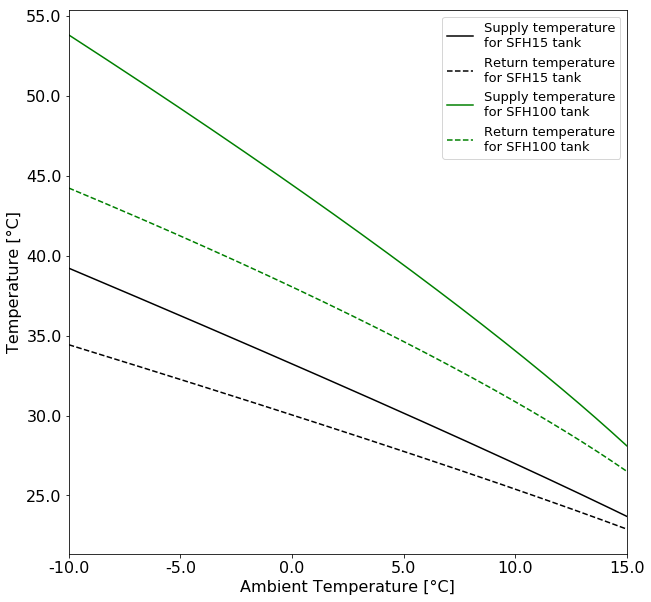

In [25]:

fig,ax=plt.subplots(figsize=(10,10))

#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_15'],label='Supply temperature\nfor SFH15 and SFH45',color='r')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_15'],label='Return temperature\nfor SFH15 and SFH45',linestyle='--',color='r')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_15_tank'],label='Supply temperature\nfor SFH15 tank',color='k')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_15_tank'],label='Return temperature\nfor SFH15 tank',color='k',linestyle='--')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_100_tank'],label='Supply temperature\nfor SFH100 tank',color='g')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_100_tank'],label='Return temperature\nfor SFH100 tank',color='g',linestyle='--')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_100'],label='Supply temperature\nfor SFH100',color='b')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_100'],label='Return temperature\nfor SFH100',color='b',linestyle='--')
#ax.axvline(-2.5,color='k',linestyle='--')
ax.set_xlim(-10,15)
ax.legend(prop={'size': normal_size-3},loc=1)
ax.set_yticklabels(ax.get_yticks(),size=normal_size)
ax.set_xticklabels(ax.get_xticks(),size=normal_size)
ax.set_ylabel('Temperature [°C]',size=normal_size)
ax.set_xlabel('Ambient Temperature [°C]',size=normal_size)
#ax.axvline(x=20,color='k',linestyle='--')

#fig.savefig('flow_return_temp.pdf')

plt.show()


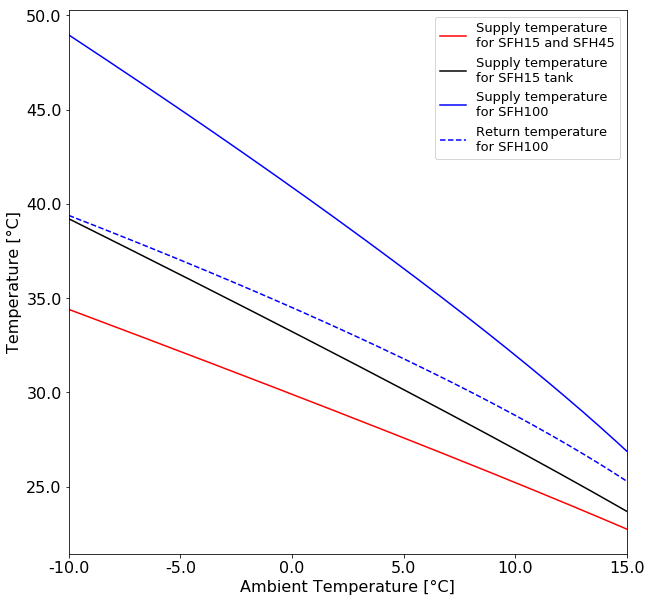

In [26]:

fig,ax=plt.subplots(figsize=(10,10))

ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_15'],label='Supply temperature\nfor SFH15 and SFH45',color='r')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_15'],label='Return temperature\nfor SFH15 and SFH45',linestyle='--',color='r')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_15_tank'],label='Supply temperature\nfor SFH15 tank',color='k')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_15_tank'],label='Return temperature\nfor SFH45',color='k',linestyle='--')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_100_tank'],label='Supply temperature\nfor SFH15 tank',color='g')
#ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_100_tank'],label='Return temperature\nfor SFH45',color='g',linestyle='--')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_100'],label='Supply temperature\nfor SFH100',color='b')
ax.plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_100'],label='Return temperature\nfor SFH100',color='b',linestyle='--')
#ax.axvline(-2.5,color='k',linestyle='--')
ax.set_xlim(-10,15)
ax.legend(prop={'size': normal_size-3},loc=1)
ax.set_yticklabels(ax.get_yticks(),size=normal_size)
ax.set_xticklabels(ax.get_xticks(),size=normal_size)
ax.set_ylabel('Temperature [°C]',size=normal_size)
ax.set_xlabel('Ambient Temperature [°C]',size=normal_size)
#ax.axvline(x=20,color='k',linestyle='--')

#fig.savefig('flow_return_temp.pdf')

plt.show()


In [27]:
df.Temp_mean=df.Temp_mean.round(1)
width=200
df.loc[:,'Temp_mean']=df.loc[:,'Temp_mean'].rolling(window=width).mean().bfill()

In [28]:
df['Temp_supply_SFH15_45']=df.apply(lambda x: supply_temp(x,dict_design['heatload_dt15'],dict_design['design_temp'],dict_design['T_dsupply_15_45'],
                                                          dict_design['T_dreturn_15_45'],dict_design['rad_exp_15_45']),axis=1)
df['Temp_supply_SFH100']=df.apply(lambda x: supply_temp(x,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],
                                                          dict_design['T_dreturn_100'],dict_design['rad_exp_100']),axis=1)
df['Temp_supply_SFH15_45_tank']=df.apply(lambda x: supply_temp(x,dict_design['heatload_dt15'],dict_design['design_temp'],dict_design['T_dsupply_15_45_tank'],
                                                          dict_design['T_dreturn_15_45_tank'],dict_design['rad_exp_15_45']),axis=1)
df['Temp_supply_SFH100_tank']=df.apply(lambda x: supply_temp(x,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],
                                                          dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100']),axis=1)


In [29]:
#def get_inlet_outlet_temp(df, dict_design):
    # '''
    # Description
    # ---------
    # Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
# Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    # Temperatures in Celsius or Kelvin
    # Parameters
    # ---------
    # df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    # dict_design:dict; design temperature, design heat load, design inlet (supply) and outlet (return) temperature
    # '''
    # if df.Temp[0]>200:#Kelvin
        # dict_design.update({'design_temp':design_temp+273.15,'T_dsupply_15_45':35+273.15,'T_dreturn_15_45':30+273.15,'T_dsupply_100':55+273.15,
             # 'T_dreturn_100':45+273.15})
    # df['Temp_supply_SFH15_45']=df.Set_T+((dict_design['T_dsupply_15_45']-dict_design['T_dreturn_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_15_45']+dict_design['T_dreturn_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    # df['Temp_supply_SFH100']=df.Set_T+((dict_design['T_dsupply_100']-dict_design['T_dreturn_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_100']+dict_design['T_dreturn_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    # df['Temp_return_SFH15_45']=df.Set_T-((dict_design['T_dsupply_15_45']-dict_design['T_dreturn_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_15_45']+dict_design['T_dreturn_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    # df['Temp_return_SFH100']=df.Set_T-((dict_design['T_dsupply_100']-dict_design['T_dreturn_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_dsupply_100']+dict_design['T_dreturn_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    # df=df.fillna(0)
    # return
# get_inlet_outlet_temp(df, dict_design)


In [30]:
df1.head()

,Temp_mean,Set_T,Supply_T_15,Supply_T_15_tank,Supply_T_100,Supply_T_100_tank,Return_T_15,Return_T_15_tank,Return_T_100,Return_T_100_tank
0,-10.0,20.0,34.406443,39.211765,48.960133,53.794905,29.620167,34.425489,39.387581,44.222353
1,-9.9,20.0,34.362056,39.152814,48.882171,53.704541,29.591734,34.382492,39.341527,44.163897
2,-9.8,20.0,34.317658,39.093848,48.804161,53.614119,29.563291,34.339481,39.295426,44.105384
3,-9.7,20.0,34.273250,39.034867,48.726102,53.523640,29.534836,34.296454,39.249276,44.046814
4,-9.6,20.0,34.228830,38.975870,48.647996,53.433103,29.506371,34.253411,39.203078,43.988185


The minimum temperature of the dataset is -7.2 °C
-11.339605655303023


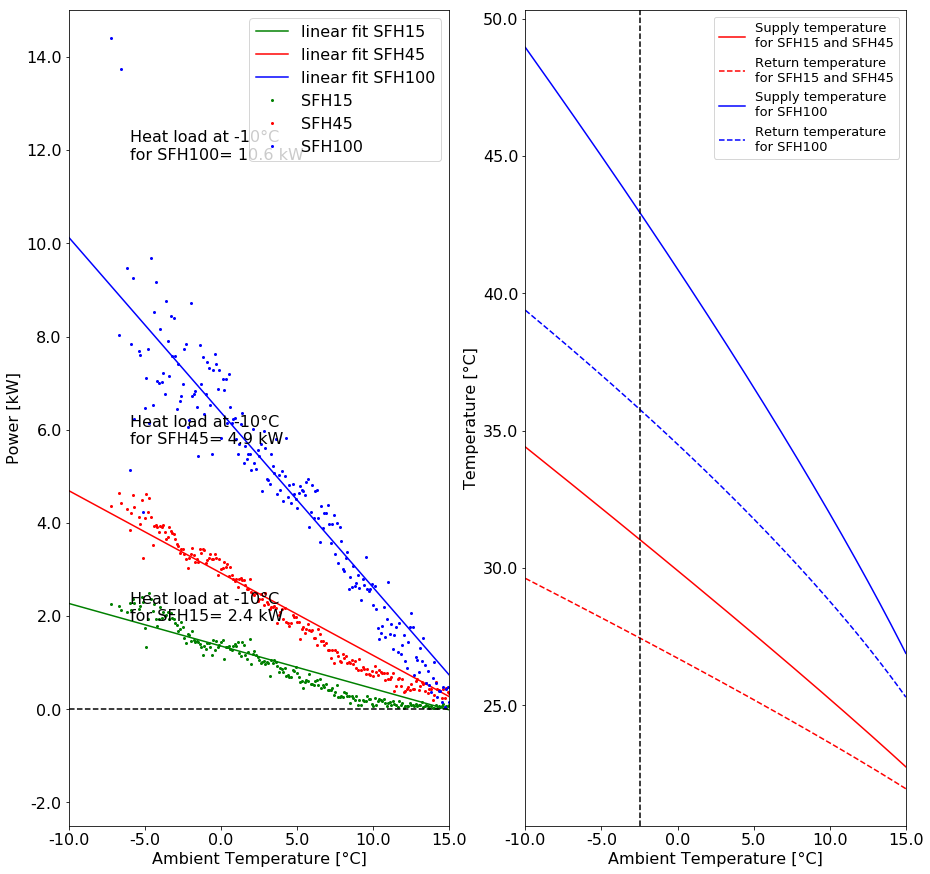

In [31]:



print('The minimum temperature of the dataset is {} °C'.format(df.Temp.min()))

fig,ax=plt.subplots(1,2,figsize=(15,15))
heat_load_ix=np.arange(-10,20,0.1)

ax[0].plot(heat_load_ix, fit_15,'g-',label='linear fit SFH15')
ax[0].plot(heat_load_ix, fit_45,'r-',label='linear fit SFH45')
ax[0].plot(heat_load_ix, fit_100,'b-',label='linear fit SFH100')
ax[0].plot(heat_load.index,heat_load.SFH15_kWh,'ro',color='g',markersize=2,label='SFH15')
ax[0].plot(heat_load.index,heat_load.SFH45_kWh,'ro',color='r',markersize=2,label='SFH45')
ax[0].plot(heat_load.index,heat_load.SFH100_kWh,'ro',color='b',markersize=2,label='SFH100')

ax[0].set_xlim(-10,15)
ax[0].set_ylim(-2.5,15)

ax[0].legend( prop={'size': normal_size})
ax[0].set_yticklabels(ax[0].get_yticks(),size=normal_size)
ax[0].set_xticklabels(ax[0].get_xticks(),size=normal_size)
ax[0].set_ylabel('Power [kW]',size=normal_size)
ax[0].set_xlabel('Ambient Temperature [°C]',size=normal_size)
conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
print(design_temp)
ax[0].axhline(y=0,color='k',linestyle='--')
ax[0].text(-6,1.9,'Heat load at -10°C\nfor SFH15= {} kW'.format(heatload_dt15.round(1)),size=normal_size)
ax[0].text(-6,5.7,'Heat load at -10°C\nfor SFH45= {} kW'.format(heatload_dt45.round(1)),size=normal_size)
ax[0].text(-6,11.8,'Heat load at -10°C\nfor SFH100= {} kW'.format(heatload_dt100.round(1)),size=normal_size)


ax[1].plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_15'],label='Supply temperature\nfor SFH15 and SFH45',color='r')
ax[1].plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_15'],label='Return temperature\nfor SFH15 and SFH45',linestyle='--',color='r')
#ax.plot(df.loc[:,'Temp_mean'],df.iloc[:,3],label='Supply temperature\nfor SFH45')
#ax.plot(df.loc[:,'Temp_mean'],df.iloc[:,6],label='Return temperature\nfor SFH45')
ax[1].plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Supply_T_100'],label='Supply temperature\nfor SFH100',color='b')
ax[1].plot(df1.loc[:,'Temp_mean'],df1.loc[:,'Return_T_100'],label='Return temperature\nfor SFH100',color='b',linestyle='--')
ax[1].axvline(-2.5,color='k',linestyle='--')
ax[1].set_xlim(-10,15)
ax[1].legend(prop={'size': normal_size-3},loc=1)
ax[1].set_yticklabels(ax[1].get_yticks(),size=normal_size)
ax[1].set_xticklabels(ax[1].get_xticks(),size=normal_size)
ax[1].set_ylabel('Temperature [°C]',size=normal_size)
ax[1].set_xlabel('Ambient Temperature [°C]',size=normal_size)
ax[1].axvline(x=20,color='k',linestyle='--')


#fig.savefig('flow_return_temp.pdf')

plt.show()

Now load the HP data from Hoval datasheet (electricity power and COP)

In [32]:
df.head()

,Hour,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_mean,Temp_supply_SFH15_45,Temp_supply_SFH100,Temp_supply_SFH15_45_tank,Temp_supply_SFH100_tank
2017-01-01 00:00:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931
2017-01-01 00:15:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931
2017-01-01 00:30:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931
2017-01-01 00:45:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931
2017-01-01 01:00:00+01:00,1,20,-2.1,0.0,0.0,0.071674,0.0,-1.712,30.685779,42.314774,34.267292,46.084931


In [33]:
df_hp=pd.read_csv('Input/HP_data.csv',sep=';')# Temperature in celcius
df_hp.loc[:,'P_el']=df_hp.loc[:,'P_el'].str.replace(',','.').astype(float)
df_hp.loc[:,'COP']=df_hp.loc[:,'COP'].str.replace(',','.').astype(float)
df_hp['P_th']=df_hp.P_el*df_hp.COP

In [34]:
df_hp.head()

,HP_rating,T_dist,T_outside,P_el,COP,P_th
0,4,30,-20,1.5,1.48,2.220
1,4,30,-15,1.5,2.16,3.240
2,4,30,-10,1.5,2.73,4.095
3,4,30,-7,1.5,3.07,4.605
4,4,30,-2,1.4,3.56,4.984


In [35]:
df=df.fillna(0)

Since we do not have exact data for the given supply and return temperature, the closest known temperature of supply at the given (closest) ambient temperature. We take this new supply temperature to use it in the model. This is done using the HP datasheet from Hoval.

In [36]:
df['HP_T_SFH15_45_to_use']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH15_45,df_hp.T_dist.unique())],axis=1)
df['HP_T_SFH100_to_use']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH100,df_hp.T_dist.unique())],axis=1)
df['HP_T_SFH15_45_tank_to_use']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH15_45_tank,df_hp.T_dist.unique())],axis=1)
df['HP_T_SFH100_tank_to_use']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH100_tank,df_hp.T_dist.unique())],axis=1)
df['Temp_amb_interval']=df.apply(lambda x: df_hp.T_outside.unique()[find_interval_hp(x.Temp,df_hp.T_outside.unique())],axis=1)

In [37]:
df.head()

,Hour,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_mean,Temp_supply_SFH15_45,Temp_supply_SFH100,Temp_supply_SFH15_45_tank,Temp_supply_SFH100_tank,HP_T_SFH15_45_to_use,HP_T_SFH100_to_use,HP_T_SFH15_45_tank_to_use,HP_T_SFH100_tank_to_use,Temp_amb_interval
2017-01-01 00:00:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931,35,45,35,50,-2
2017-01-01 00:15:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931,35,45,35,50,-2
2017-01-01 00:30:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931,35,45,35,50,-2
2017-01-01 00:45:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,34.267292,46.084931,35,45,35,50,-2
2017-01-01 01:00:00+01:00,1,20,-2.1,0.0,0.0,0.071674,0.0,-1.712,30.685779,42.314774,34.267292,46.084931,35,45,35,50,-2


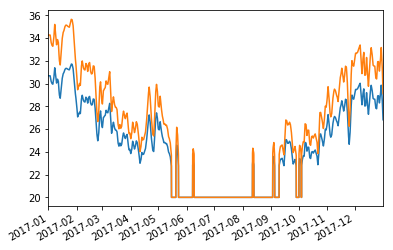

In [38]:
df.Temp_supply_SFH15_45.plot()
df.Temp_supply_SFH15_45_tank.plot()
plt.show()

In [39]:
def hp_sizing(dict_design,df_hp):
    '''
    Get the HP rating according to the design temperature (in the interval of the input HP data) and the inlet temperature design.
    It returns the HP rating that provides the closest power to the required, if the HP cannot provide the required heat power, a backup 
    heater is required.
    '''
    desig_temp_hp_data=df_hp.T_outside.unique()[find_interval_hp(dict_design['design_temp'],df_hp.T_outside.unique())]    
    hp_15=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_15_45'])].P_th-dict_design['heatload_dt15']).idxmin,'HP_rating']
    hp_45=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_15_45'])].P_th-dict_design['heatload_dt45']).idxmin,'HP_rating']
    hp_100=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_100'])].P_th-dict_design['heatload_dt100']).idxmin,'HP_rating']
    bu_100=np.ceil(max(0,dict_design['heatload_dt100']-df_hp.loc[(df_hp.HP_rating==hp_100)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_100']),'P_th'].values[0]))
    bu_45=np.ceil(max(0,dict_design['heatload_dt45']-df_hp.loc[(df_hp.HP_rating==hp_45)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_15_45']),'P_th'].values[0]))
    bu_15=np.ceil(max(0,dict_design['heatload_dt15']-df_hp.loc[(df_hp.HP_rating==hp_15)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_15_45']),'P_th'].values[0]))
    dict_design.update({'hp_15':hp_15,'hp_45':hp_45,'hp_100':hp_100,'bu_15':bu_15,'bu_45':bu_45,'bu_100':bu_100})
    return

In [40]:
hp_sizing(dict_design,df_hp)

In [41]:
dict_design

{'heatload_dt15': 2.394,
 'heatload_dt45': 4.929,
 'heatload_dt100': 10.631,
 'design_temp': -11.339605655303023,
 'T_dsupply_15_45': 35,
 'T_dreturn_15_45': 30,
 'T_dsupply_100': 50,
 'T_dreturn_100': 40,
 'T_dsupply_15_45_tank': 40,
 'T_dreturn_15_45_tank': 35,
 'T_dsupply_100_tank': 55,
 'T_dreturn_100_tank': 45,
 'rad_exp_15_45': 1.1,
 'rad_exp_100': 1.3,
 'hp_15': 4,
 'hp_45': 6,
 'hp_100': 16,
 'bu_15': 0.0,
 'bu_45': 1.0,
 'bu_100': 1.0}

In [42]:
def get_COP(df,df_hp,dict_design):
    '''
    Calculates the COP for the three house types as well as the hp consumption (electricity, in kW) according to the HP rating, inlet temperature 
    and ambient temperature
    TODO
    -----
    include dt (here 15 minutes)
    '''
    df['COP_SFH15']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.HP_T_SFH15_45_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH45']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.HP_T_SFH15_45_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH100']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['COP_SFH15_tank']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.HP_T_SFH15_45_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH45_tank']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.HP_T_SFH15_45_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH100_tank']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['COP_SFH15_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH45_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH100_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['hp_SFH15_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.HP_T_SFH15_45_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH45_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.HP_T_SFH15_45_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH100_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    
    df['hp_SFH15_tank_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.HP_T_SFH15_45_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH45_tank_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.HP_T_SFH15_45_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH100_tank_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    
    df['hp_SFH15_el_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH45_el_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    df['hp_SFH100_el_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    return

In [43]:
get_COP(df,df_hp,dict_design)

In [44]:
df.head()

,Hour,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_mean,Temp_supply_SFH15_45,Temp_supply_SFH100,...,COP_SFH100_DHW,hp_SFH15_el_cons,hp_SFH45_el_cons,hp_SFH100_el_cons,hp_SFH15_tank_el_cons,hp_SFH45_tank_el_cons,hp_SFH100_tank_el_cons,hp_SFH15_el_cons_DHW,hp_SFH45_el_cons_DHW,hp_SFH100_el_cons_DHW
2017-01-01 00:00:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:15:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:30:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:45:00+01:00,0,20,-2.0,0.0,0.0,0.137079,0.0,-1.712,30.685779,42.314774,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 01:00:00+01:00,1,20,-2.1,0.0,0.0,0.071674,0.0,-1.712,30.685779,42.314774,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8


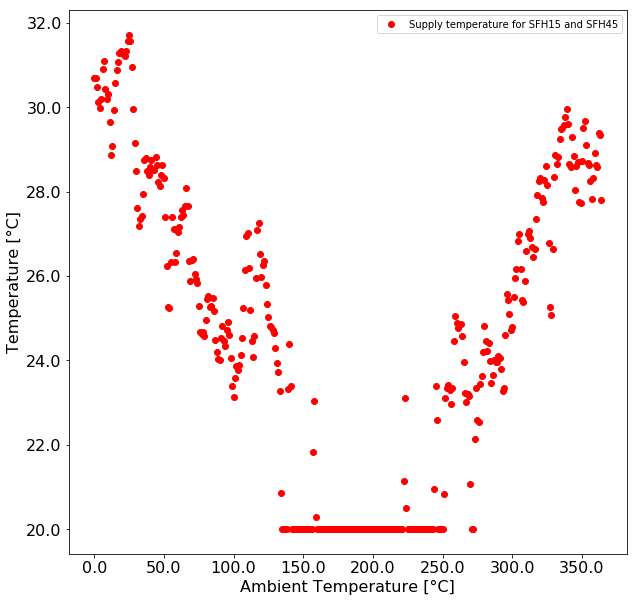

In [45]:

fig,ax=plt.subplots(figsize=(10,10))
df_gp=df.groupby([df.index.month,df.index.day]).mean().Temp_supply_SFH15_45
df_gp[df_gp == 0] = 'nan'
ax.plot(df_gp.reset_index(drop=True),'ro',color='r',label='Supply temperature for SFH15 and SFH45')


ax.legend()
ax.set_yticklabels(ax.get_yticks(),size=normal_size)
ax.set_xticklabels(ax.get_xticks(),size=normal_size)
ax.set_ylabel('Temperature [°C]',size=normal_size)
ax.set_xlabel('Ambient Temperature [°C]',size=normal_size)

plt.show()

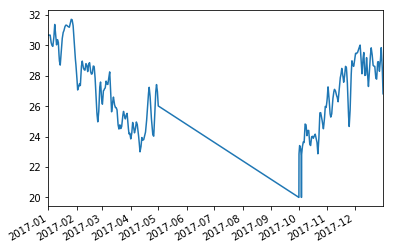

In [46]:
df[(df.index.month<=4)|(df.index.month>=10)].Temp_supply_SFH15_45.plot()

In [47]:
df.keys()

Index(['Hour', 'Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh',
       'DHW_kWh', 'Temp_mean', 'Temp_supply_SFH15_45', 'Temp_supply_SFH100',
       'Temp_supply_SFH15_45_tank', 'Temp_supply_SFH100_tank',
       'HP_T_SFH15_45_to_use', 'HP_T_SFH100_to_use',
       'HP_T_SFH15_45_tank_to_use', 'HP_T_SFH100_tank_to_use',
       'Temp_amb_interval', 'COP_SFH15', 'COP_SFH45', 'COP_SFH100',
       'COP_SFH15_tank', 'COP_SFH45_tank', 'COP_SFH100_tank', 'COP_SFH15_DHW',
       'COP_SFH45_DHW', 'COP_SFH100_DHW', 'hp_SFH15_el_cons',
       'hp_SFH45_el_cons', 'hp_SFH100_el_cons', 'hp_SFH15_tank_el_cons',
       'hp_SFH45_tank_el_cons', 'hp_SFH100_tank_el_cons',
       'hp_SFH15_el_cons_DHW', 'hp_SFH45_el_cons_DHW',
       'hp_SFH100_el_cons_DHW'],
      dtype='object')

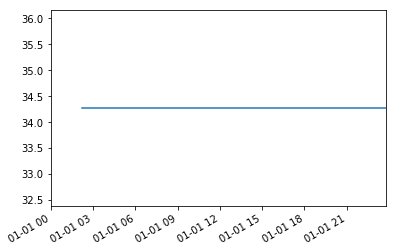

In [48]:
width=10
df[df.index.dayofyear==1].Temp_supply_SFH15_45_tank.rolling(window=width).mean().plot()

In [49]:
width=200
#df[(df.index.dayofyear>92)&(df.index.dayofyear<96)].Temp.plot()
(df.Temp_supply_SFH15_45_tank-df.Temp_supply_SFH15_45).mean()#.rolling(window=width).mean().bfill().plot()
#.plot()#.rolling(window=width).mean().bfill().plot()

1.5353459937351956

In [50]:
df[(df.index.dayofyear<120)&(df.Temp_supply_SFH15_45<2)].empty

True

In [51]:
df[((df.index.dayofyear<120)|(df.index.dayofyear>274))&(df.Temp_supply_SFH15_45==df.Temp_supply_SFH15_45_tank)].empty

False

In [52]:
df.max()

Hour                         8759.000000
Set_T                          20.000000
Temp                           35.600000
SFH15_kWh                       0.636620
SFH45_kWh                       1.219240
SFH100_kWh                      4.272850
DHW_kWh                         1.354213
Temp_mean                      28.120000
Temp_supply_SFH15_45           31.722104
Temp_supply_SFH100             44.190053
Temp_supply_SFH15_45_tank      35.645142
Temp_supply_SFH100_tank        48.262259
HP_T_SFH15_45_to_use           35.000000
HP_T_SFH100_to_use             45.000000
HP_T_SFH15_45_tank_to_use      40.000000
HP_T_SFH100_tank_to_use        50.000000
Temp_amb_interval              20.000000
COP_SFH15                       8.140000
COP_SFH45                       6.540000
COP_SFH100                      6.430000
COP_SFH15_tank                  8.140000
COP_SFH45_tank                  6.540000
COP_SFH100_tank                 6.430000
COP_SFH15_DHW                   3.370000
COP_SFH45_DHW   

In [53]:
df[df.index.dayofyear==88].count()

Hour                         96
Set_T                        96
Temp                         96
SFH15_kWh                    96
SFH45_kWh                    96
SFH100_kWh                   96
DHW_kWh                      96
Temp_mean                    96
Temp_supply_SFH15_45         96
Temp_supply_SFH100           96
Temp_supply_SFH15_45_tank    96
Temp_supply_SFH100_tank      96
HP_T_SFH15_45_to_use         96
HP_T_SFH100_to_use           96
HP_T_SFH15_45_tank_to_use    96
HP_T_SFH100_tank_to_use      96
Temp_amb_interval            96
COP_SFH15                    96
COP_SFH45                    96
COP_SFH100                   96
COP_SFH15_tank               96
COP_SFH45_tank               96
COP_SFH100_tank              96
COP_SFH15_DHW                96
COP_SFH45_DHW                96
COP_SFH100_DHW               96
hp_SFH15_el_cons             96
hp_SFH45_el_cons             96
hp_SFH100_el_cons            96
hp_SFH15_tank_el_cons        96
hp_SFH45_tank_el_cons        96
hp_SFH10

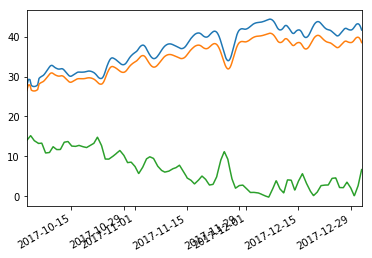

In [54]:
df.Temp_supply_SFH100_tank.rolling(window=width).mean().bfill()[((df.index.dayofyear>275))].plot()
df.Temp_supply_SFH100.rolling(window=width).mean().bfill()[((df.index.dayofyear>275))].plot()
df.Temp_mean[((df.index.dayofyear>275))].plot()

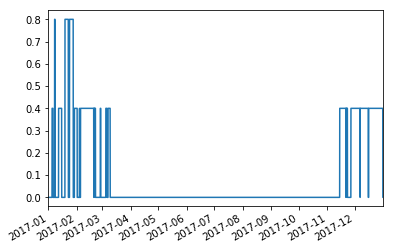

In [55]:
(df.hp_SFH15_tank_el_cons*4-df.hp_SFH15_el_cons*4).plot()


In [56]:
cols=[ 'Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh',
       'DHW_kWh', 'Temp_supply_SFH15_45', 'Temp_supply_SFH100',
       'Temp_supply_SFH15_45_tank', 'Temp_supply_SFH100_tank',
       'COP_SFH15', 'COP_SFH45', 'COP_SFH100',
       'COP_SFH15_tank', 'COP_SFH45_tank', 'COP_SFH100_tank', 'COP_SFH15_DHW',
       'COP_SFH45_DHW', 'COP_SFH100_DHW', 'hp_SFH15_el_cons',
       'hp_SFH45_el_cons', 'hp_SFH100_el_cons', 'hp_SFH15_tank_el_cons',
       'hp_SFH45_tank_el_cons', 'hp_SFH100_tank_el_cons',
       'hp_SFH15_el_cons_DHW', 'hp_SFH45_el_cons_DHW',
       'hp_SFH100_el_cons_DHW']

In [57]:
df[df.index.dayofyear==9].Set_T+273.15

2017-01-09 00:00:00+01:00    293.15
2017-01-09 00:15:00+01:00    293.15
2017-01-09 00:30:00+01:00    293.15
2017-01-09 00:45:00+01:00    293.15
2017-01-09 01:00:00+01:00    293.15
2017-01-09 01:15:00+01:00    293.15
2017-01-09 01:30:00+01:00    293.15
2017-01-09 01:45:00+01:00    293.15
2017-01-09 02:00:00+01:00    293.15
2017-01-09 02:15:00+01:00    293.15
2017-01-09 02:30:00+01:00    293.15
2017-01-09 02:45:00+01:00    293.15
2017-01-09 03:00:00+01:00    293.15
2017-01-09 03:15:00+01:00    293.15
2017-01-09 03:30:00+01:00    293.15
2017-01-09 03:45:00+01:00    293.15
2017-01-09 04:00:00+01:00    293.15
2017-01-09 04:15:00+01:00    293.15
2017-01-09 04:30:00+01:00    293.15
2017-01-09 04:45:00+01:00    293.15
2017-01-09 05:00:00+01:00    293.15
2017-01-09 05:15:00+01:00    293.15
2017-01-09 05:30:00+01:00    293.15
2017-01-09 05:45:00+01:00    293.15
2017-01-09 06:00:00+01:00    293.15
2017-01-09 06:15:00+01:00    293.15
2017-01-09 06:30:00+01:00    293.15
2017-01-09 06:45:00+01:00   

In [58]:
df_out=df.reindex(cols,axis='columns')

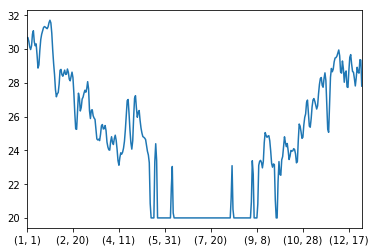

In [59]:
df_out.groupby([df_out.index.month,df_out.index.day]).mean().Temp_supply_SFH15_45.plot()

In [60]:
df.keys()

Index(['Hour', 'Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh',
       'DHW_kWh', 'Temp_mean', 'Temp_supply_SFH15_45', 'Temp_supply_SFH100',
       'Temp_supply_SFH15_45_tank', 'Temp_supply_SFH100_tank',
       'HP_T_SFH15_45_to_use', 'HP_T_SFH100_to_use',
       'HP_T_SFH15_45_tank_to_use', 'HP_T_SFH100_tank_to_use',
       'Temp_amb_interval', 'COP_SFH15', 'COP_SFH45', 'COP_SFH100',
       'COP_SFH15_tank', 'COP_SFH45_tank', 'COP_SFH100_tank', 'COP_SFH15_DHW',
       'COP_SFH45_DHW', 'COP_SFH100_DHW', 'hp_SFH15_el_cons',
       'hp_SFH45_el_cons', 'hp_SFH100_el_cons', 'hp_SFH15_tank_el_cons',
       'hp_SFH45_tank_el_cons', 'hp_SFH100_tank_el_cons',
       'hp_SFH15_el_cons_DHW', 'hp_SFH45_el_cons_DHW',
       'hp_SFH100_el_cons_DHW'],
      dtype='object')

In [61]:
df_out.head()

,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_supply_SFH15_45,Temp_supply_SFH100,Temp_supply_SFH15_45_tank,Temp_supply_SFH100_tank,...,COP_SFH100_DHW,hp_SFH15_el_cons,hp_SFH45_el_cons,hp_SFH100_el_cons,hp_SFH15_tank_el_cons,hp_SFH45_tank_el_cons,hp_SFH100_tank_el_cons,hp_SFH15_el_cons_DHW,hp_SFH45_el_cons_DHW,hp_SFH100_el_cons_DHW
2017-01-01 00:00:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:15:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:30:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:45:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 01:00:00+01:00,20,-2.1,0.0,0.0,0.071674,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8


In [62]:
df_out.index

DatetimeIndex(['2017-01-01 00:00:00+01:00', '2017-01-01 00:15:00+01:00',
               '2017-01-01 00:30:00+01:00', '2017-01-01 00:45:00+01:00',
               '2017-01-01 01:00:00+01:00', '2017-01-01 01:15:00+01:00',
               '2017-01-01 01:30:00+01:00', '2017-01-01 01:45:00+01:00',
               '2017-01-01 02:00:00+01:00', '2017-01-01 02:15:00+01:00',
               ...
               '2017-12-31 21:30:00+01:00', '2017-12-31 21:45:00+01:00',
               '2017-12-31 22:00:00+01:00', '2017-12-31 22:15:00+01:00',
               '2017-12-31 22:30:00+01:00', '2017-12-31 22:45:00+01:00',
               '2017-12-31 23:00:00+01:00', '2017-12-31 23:15:00+01:00',
               '2017-12-31 23:30:00+01:00', '2017-12-31 23:45:00+01:00'],
              dtype='datetime64[ns, Europe/Brussels]', length=35040, freq=None)

In [63]:
df_out.keys()

Index(['Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh', 'DHW_kWh',
       'Temp_supply_SFH15_45', 'Temp_supply_SFH100',
       'Temp_supply_SFH15_45_tank', 'Temp_supply_SFH100_tank', 'COP_SFH15',
       'COP_SFH45', 'COP_SFH100', 'COP_SFH15_tank', 'COP_SFH45_tank',
       'COP_SFH100_tank', 'COP_SFH15_DHW', 'COP_SFH45_DHW', 'COP_SFH100_DHW',
       'hp_SFH15_el_cons', 'hp_SFH45_el_cons', 'hp_SFH100_el_cons',
       'hp_SFH15_tank_el_cons', 'hp_SFH45_tank_el_cons',
       'hp_SFH100_tank_el_cons', 'hp_SFH15_el_cons_DHW',
       'hp_SFH45_el_cons_DHW', 'hp_SFH100_el_cons_DHW'],
      dtype='object')

In [72]:
df_out.reset_index().to_csv('Input/preprocessed_heat_demand_2_new.csv',sep=';')

In [65]:
df.nsmallest(20000,'Temp_supply_SFH15_45').Temp_supply_SFH15_45.unique()

array([20.        , 22.75552807, 22.75629037, ..., 25.28296673,
       25.28344832, 25.28392991])

In [66]:
df_out[df_out.index.dayofyear==4]

,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_supply_SFH15_45,Temp_supply_SFH100,Temp_supply_SFH15_45_tank,Temp_supply_SFH100_tank,...,COP_SFH100_DHW,hp_SFH15_el_cons,hp_SFH45_el_cons,hp_SFH100_el_cons,hp_SFH15_tank_el_cons,hp_SFH45_tank_el_cons,hp_SFH100_tank_el_cons,hp_SFH15_el_cons_DHW,hp_SFH45_el_cons_DHW,hp_SFH100_el_cons_DHW
2017-01-04 00:00:00+01:00,20,-4.4,0.594960,1.064475,1.834670,0.040298,30.222553,41.469561,33.651228,45.103126,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 00:15:00+01:00,20,-4.4,0.594960,1.064475,1.834670,0.000000,30.220271,41.465386,33.648193,45.098277,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 00:30:00+01:00,20,-4.4,0.594960,1.064475,1.834670,0.013757,30.217990,41.461212,33.645158,45.093427,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 00:45:00+01:00,20,-4.4,0.594960,1.064475,1.834670,0.005828,30.215708,41.457037,33.642124,45.088577,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 01:00:00+01:00,20,-4.6,0.601973,1.089850,1.414833,0.000000,30.213427,41.452862,33.639089,45.083727,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 01:15:00+01:00,20,-4.6,0.601973,1.089850,1.414833,0.000000,30.211145,41.448687,33.636054,45.078876,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 01:30:00+01:00,20,-4.6,0.601973,1.089850,1.414833,0.000000,30.208863,41.444512,33.633019,45.074025,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 01:45:00+01:00,20,-4.6,0.601973,1.089850,1.414833,0.000000,30.206581,41.440337,33.629984,45.069174,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 02:00:00+01:00,20,-4.8,0.608820,0.926643,2.489228,0.007091,30.204756,41.436996,33.627556,45.065293,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-04 02:15:00+01:00,20,-4.8,0.608820,0.926643,2.489228,0.000000,30.202930,41.433656,33.625128,45.061412,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8


In [67]:
df_out.head()

,Set_T,Temp,SFH15_kWh,SFH45_kWh,SFH100_kWh,DHW_kWh,Temp_supply_SFH15_45,Temp_supply_SFH100,Temp_supply_SFH15_45_tank,Temp_supply_SFH100_tank,...,COP_SFH100_DHW,hp_SFH15_el_cons,hp_SFH45_el_cons,hp_SFH100_el_cons,hp_SFH15_tank_el_cons,hp_SFH45_tank_el_cons,hp_SFH100_tank_el_cons,hp_SFH15_el_cons_DHW,hp_SFH45_el_cons_DHW,hp_SFH100_el_cons_DHW
2017-01-01 00:00:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:15:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:30:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 00:45:00+01:00,20,-2.0,0.0,0.0,0.137079,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8
2017-01-01 01:00:00+01:00,20,-2.1,0.0,0.0,0.071674,0.0,30.685779,42.314774,34.267292,46.084931,...,1.62,1.5,2.0,5.5,1.5,2.0,5.8,2.2,2.5,5.8


In [68]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [69]:
save_obj(dict_design,'dict_design')

In [70]:

df_out.keys()

Index(['Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh', 'DHW_kWh',
       'Temp_supply_SFH15_45', 'Temp_supply_SFH100',
       'Temp_supply_SFH15_45_tank', 'Temp_supply_SFH100_tank', 'COP_SFH15',
       'COP_SFH45', 'COP_SFH100', 'COP_SFH15_tank', 'COP_SFH45_tank',
       'COP_SFH100_tank', 'COP_SFH15_DHW', 'COP_SFH45_DHW', 'COP_SFH100_DHW',
       'hp_SFH15_el_cons', 'hp_SFH45_el_cons', 'hp_SFH100_el_cons',
       'hp_SFH15_tank_el_cons', 'hp_SFH45_tank_el_cons',
       'hp_SFH100_tank_el_cons', 'hp_SFH15_el_cons_DHW',
       'hp_SFH45_el_cons_DHW', 'hp_SFH100_el_cons_DHW'],
      dtype='object')

In [71]:
df_out.Temp_su

AttributeError: 'DataFrame' object has no attribute 'Temp_su'